# Figures for the manuscript titled: Data-efficient U-Net for Segmentation of Carbide Microstructures in SEM Images of Steel Alloys

This notebook (re)creates the figures for the manuscript

In [1]:
from pathlib import Path
import random
from typing import List

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage.io import imread
import svgutils.compose as sc
from IPython.display import SVG

import torch
from torch.utils.data import DataLoader, Subset
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from carde.io import image_path, label_path, tiled_image_path, tiled_label_path
from carde.io import read_image_pair, get_image_number
from carde.image_processing import save_paired_tiles, tile_image, RobustImageScaler
from carde.dataset import SEMTileDataset, split_data
from carde.unet import SegmentationModel
from carde.evalmetrics import evaluate_model, plot_as_confidence_map, plot_confidence_map, logits_to_confidence_map
import carde

## Figure parameters

In [2]:
devices=(0,)
_ = torch.manual_seed(42)
np.random.seed(5)
random.seed(13)
device_name = f"cuda:{devices[0]}" if torch.cuda.is_available() else "cpu"

# figure parameters
plt.rcParams['svg.fonttype'] = 'none'  # editable text in svg vector formats
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']

# figure sizes
textwidth = 7.05  # inches
onecolumn = 3.42  # inches
# set the default figure size to one column width
plt.rcParams["figure.figsize"] = (textwidth, onecolumn)

figure_path = Path('../paper/figures')
figure_path.mkdir(parents=True, exist_ok=True)

## Image metadata for scale bars

In [3]:
pixel_size = 8  # nanometers per pixel
scale_bar_length = 300  # nanometers
scale_bar_length_px = scale_bar_length / pixel_size  # in pixels

## Figure 1: Data and model architecture

In [4]:
raw_image_path = image_path.parent.parent / "01-02"
se2_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_001.tif")
in_lens_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_002.tif")
label_image = imread(raw_image_path / "05a_Particle_Image_Filtered.bmp")

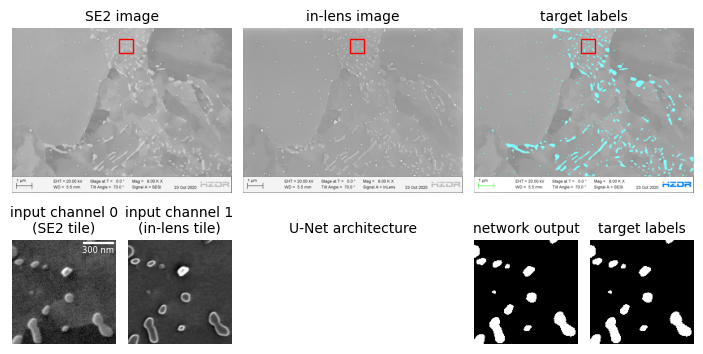

In [5]:
layout = [["A", "A", "B", "B", "C", "C"], ["A", "A", "B", "B", "C", "C"], ["D", "E", "F", "F", "G", "H"]]
fig, ax = plt.subplot_mosaic(layout, figsize=(textwidth, 3.7))
axs = list(ax.values())
axs[0].imshow(se2_image, cmap='gray')
axs[0].set_title('SE2 image')
axs[1].imshow(in_lens_image, cmap='gray')
axs[1].set_title('in-lens image')
axs[2].imshow(label_image)
axs[2].set_title('target labels')
y_slice = slice(100, 228)
x_slice = slice(1000, 1128)
in_se2_tile = se2_image[y_slice, x_slice]
axs[3].imshow(in_se2_tile, cmap='gray')
axs[3].set_title('input channel 0\n(SE2 tile)')

scalebar = AnchoredSizeBar(
    axs[3].transData,
    scale_bar_length_px,
    f"{scale_bar_length} nm",
    "upper right",
    pad=0.1,
    color="white",
    frameon=False,
    size_vertical=1,
    fontproperties={"size": 6},
)
axs[3].add_artist(scalebar)
in_lens_tile = in_lens_image[y_slice, x_slice]
axs[4].imshow(in_lens_tile, cmap='gray')
axs[4].set_title('input channel 1\n(in-lens tile)')
label_tile = label_image[y_slice, x_slice]
label_tile = np.logical_and(
    label_tile[:, :, 0] == 128,
    label_tile[:, :, 1] == 255,
    label_tile[:, :, 2] == 255,
)
# axs[5] is a placeholder for the network architecture
axs[5].set_title('U-Net architecture')
axs[6].imshow(label_tile, cmap='gray')
axs[6].set_title('network output')
axs[7].imshow(label_tile, cmap='gray')
axs[7].set_title('target labels')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
# draw rectangle around the tiles in the full images
for n in range(3):
    rect = plt.Rectangle((x_slice.start, y_slice.start), x_slice.stop - x_slice.start, y_slice.stop - y_slice.start,
                     edgecolor='red', facecolor='none', linewidth=1)
    axs[n].add_patch(rect)
plt.savefig(figure_path / "figure_1_data_and_model.svg", dpi=300)

In [6]:
# combine with the U-Net architecture figure in u-net-scheme.svg
figure_height = fig.get_figheight()

fig1 = sc.Figure(
    f"{textwidth * 2.54}cm",
    f"{figure_height * 2.54}cm",
    sc.Panel(
        sc.SVG(figure_path / "figure_1_data_and_model.svg").scale(1, 1).move(0, 0),
        sc.SVG(figure_path / "u-net-scheme.svg").scale(0.6, 0.6).move(2.4 * 72, 2.53 * 72),
    ),
)
scale_factor = 10.5 / 300  # to compensate for weird svgutils scaling
fig1.scale(scale_factor,scale_factor).save(figure_path / "figure_1_data_and_model_combined.svg")
SVG(figure_path / "figure_1_data_and_model_combined.svg")

## Figure 2: Model training

In [7]:
model_path = tiled_label_path.parent.parent / "tb_logs"

In [8]:
# create dataset
dataset = SEMTileDataset(tiled_image_path, tiled_label_path, train=True)
# create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# split data into three sets: train, validation, and test
train_loader, val_loader, test_loader = split_data(dataset, batch_size=32, train_ratio=0.8, val_ratio=0.1)

In [9]:
print(f"Batches in training data loader: {len(train_loader)}")
print(f"Batches in validation data loader: {len(val_loader)}")
print(f"Batches in test data loader: {len(test_loader)}")

print(f"Number of samples in training data loader: {len(train_loader.dataset)}")
print(f"Number of samples in validation data loader: {len(val_loader.dataset)}")
print(f"Number of samples in test data loader: {len(test_loader.dataset)}")

total_samples = len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)
print(f"Total number of samples: {total_samples}")


Batches in training data loader: 48
Batches in validation data loader: 6
Batches in test data loader: 6
Number of samples in training data loader: 1536
Number of samples in validation data loader: 192
Number of samples in test data loader: 192
Total number of samples: 1920


In [10]:
# load existing model if available

model_path.mkdir(parents=True, exist_ok=True)
checkpoint_paths = list(model_path.glob("**/*.ckpt"))
if checkpoint_paths:
    print(f"Found existing checkpoints: {list(checkpoint_paths)}. Using the latest one for training.")
    checkpoint_path = max(checkpoint_paths, key=lambda p: p.stat().st_mtime)
    print(f"Loading checkpoint from {checkpoint_path}")
else:
    checkpoint_path = None
    print("No checkpoints found. Starting training from scratch.")

Found existing checkpoints: [PosixPath('../../data/cloud/tb_logs/unet_model/version_0/checkpoints/epoch=110-step=5328.ckpt')]. Using the latest one for training.
Loading checkpoint from ../../data/cloud/tb_logs/unet_model/version_0/checkpoints/epoch=110-step=5328.ckpt


In [11]:
# TensorBoard Logger
logger = TensorBoardLogger(str(model_path), name="unet_model")
logger

In [12]:
# training the model
early_stop_callback = EarlyStopping(monitor="validation_loss", mode="min", patience=14, verbose=True) 

model = SegmentationModel(
    in_channels=2, out_channels=1, lr=0.0002, lr_scheduler_patience=7, blocks=3, hidden_layers_block1=128
)

trainer = pl.Trainer(max_epochs=1000, accelerator="gpu", devices=devices, enable_progress_bar=True, callbacks=[early_stop_callback], logger=logger)
if checkpoint_path is not None:
    trainer.fit(model, train_loader, val_loader, ckpt_path=str(checkpoint_path))
else:
    trainer.fit(model, train_loader, val_loader)

/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 15 records. Best score: 0.045. Signaling Trainer to stop.


In [13]:
avg_loss, avg_score = evaluate_model(model, val_loader, trainer, show_sample=False, n_samples=3)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.04653097689151764
       test_score           0.9534690976142883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Average Dice Loss: 0.0465
Average 1 - Dice Loss: 0.9535


In [14]:
def plot_loss(event_acc, axs:List[Axes], yscale='linear'):

    # extract training/validation curves
    train_loss_scalars = event_acc.Scalars("train_loss_epoch")
    val_loss_scalars   = event_acc.Scalars("validation_loss")
    val_score_scalars  = event_acc.Scalars("validation_score")

    # convert to numpy arrays [step, value]
    train_loss = np.array([[s.step, s.value] for s in train_loss_scalars])
    val_loss   = np.array([[s.step, s.value] for s in val_loss_scalars])
    val_score  = np.array([[s.step, s.value] for s in val_score_scalars])

    if train_loss.size:
        axs[0].plot(train_loss[:, 0], train_loss[:, 1], label="train loss")
    if val_loss.size:
        axs[0].plot(val_loss[:, 0], val_loss[:, 1], label="validation loss")

    axs[0].set_xlabel("step")
    axs[0].set_ylabel("loss")
    axs[0].set_yscale(yscale)
    axs[0].legend() 

    if val_score.size:
        axs[1].plot(val_score[:, 0], val_score[:, 1], label="validation score")
        axs[1].set_xlabel("step")
        axs[1].set_ylabel("Dice-Sørensen\ncoefficient")
        axs[1].set_ylim(0, 1)
        # move ylabel to the right
        # axs[1].yaxis.set_label_position("right")
        # axs[1].yaxis.tick_right()
        axs[1].legend() 

    return axs

In [15]:
log_dir = model_path / "unet_model" / "version_0"
event_acc = EventAccumulator(str(log_dir))

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['validation_loss', 'validation_score', 'epoch', 'train_loss_epoch', 'train_loss_step', 'test_loss', 'test_score'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


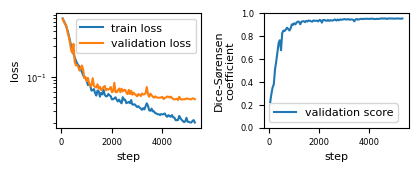

In [16]:
# event_acc = EventAccumulator(trainer.logger.log_dir)
event_acc.Reload()
print(event_acc.Tags())

layout = [["Loss", "Score"]]
fig, ax = plt.subplot_mosaic(layout, figsize=(textwidth * 0.6, textwidth/4))
axs = list(ax.values())
plot_loss(event_acc, axs=axs[:2], yscale="log")
fig.tight_layout()
fig.savefig(figure_path / "figure_2_training_results.svg", dpi=300)


## Figure 3: model evaluation

In [17]:
def classical_segmentation(images: torch.Tensor):
    segmented = carde.segment_combined(images[0].cpu().numpy(), images[1].cpu().numpy())
    return torch.tensor(segmented > 0, dtype=torch.float32)

In [18]:
def calculate_classical_unet_scores(model: SegmentationModel, test_data_loader: DataLoader, trainer: pl.Trainer, device='cpu'):
    unet_scores = []
    baseline_scores = []
    predictions = [torch.nn.Sigmoid()(p) for p in trainer.predict(model, test_data_loader)]

    for n, (inputs, labels) in enumerate(test_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        score = 1 - model.dice_loss(predictions[n].to(device), labels)

        unet_scores.extend([float(v) for v in score.squeeze()])

        for i in range(inputs.size(0)):
            pred = classical_segmentation(inputs[i]).to(device)
            # add batch dimension and channel dimension
            pred = pred.unsqueeze(0).unsqueeze(0)
            label = labels[i].unsqueeze(0)
            baseline_score = 1 - model.dice_loss(pred, label)

            baseline_scores.append(float(baseline_score.squeeze()))
    return baseline_scores, unet_scores

In [19]:
baseline_scores, unet_scores = calculate_classical_unet_scores(
    model=model,
    test_data_loader=test_loader,
    trainer=trainer,
    device="cuda",
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [20]:
# create dataframe for seaborn
df = pd.DataFrame({
    'score': baseline_scores + unet_scores,
    'method': ['Baseline'] * len(baseline_scores) + ['U-Net'] * len(unet_scores)
})

In [21]:
# Check statistical significance using a Wilcoxon signed-rank test
from scipy.stats import wilcoxon
C, p = wilcoxon(baseline_scores, unet_scores)
print(f"Median (IQR) baseline score: {np.median(baseline_scores):.2f} ({np.percentile(baseline_scores, 25):.3f} - {np.percentile(baseline_scores, 75):.3f})")
print(f"Median (IQR) U-Net score: {np.median(unet_scores):.2f} ({np.percentile(unet_scores, 25):.3f} - {np.percentile(unet_scores, 75):.3f})")
print(f"Wilcoxon signed-rank test: C={C}, p-value={p}")

Median (IQR) baseline score: 0.85 (0.522 - 0.919)
Median (IQR) U-Net score: 0.98 (0.964 - 0.991)
Wilcoxon signed-rank test: C=5.0, p-value=3.183315689561662e-33


In [22]:
# SE2, InLens, Label, Prediction
def plot_predictions(
    model: SegmentationModel, test_data_loader: DataLoader, trainer: pl.Trainer, n_samples=3, axs=None, fig=None
):
    optimal_T = torch.Tensor([1.87117]).to(device_name)  # determined from the validation set in the notebook Uncertainty_quantification.ipynb
    inputs, labels = next(iter(test_data_loader))

    idxs = random.sample(range(inputs.size(0)), n_samples)
    if axs is None:
        fig, ax = plt.subplots(n_samples, 5, figsize=(textwidth, 4 * n_samples))
        axs = ax.ravel()
    else:
        assert len(axs) == n_samples * 5, f"axs must have n_samples * 5 = {n_samples * 5} axes, got {len(axs)}"
    for i, idx in enumerate(idxs):
        baseline = classical_segmentation(inputs[idx])
        axs_index = i * 5
        axs[axs_index + 0].imshow(inputs[idx, 0].cpu(), cmap="gray")
        axs[axs_index + 1].imshow(inputs[idx, 1].cpu(), cmap="gray")
        plot_as_confidence_map((labels[idx, 0].cpu() > 0) * 3, ax=axs[axs_index + 2], fig=fig, color_bar=False)
        axs[axs_index + 2].set_title("")
        plot_as_confidence_map(baseline * 3, ax=axs[axs_index + 3], fig=fig, color_bar=False)
        axs[axs_index + 3].set_title("")
        single_image_loader = DataLoader(Subset(test_data_loader.dataset, [idx]), batch_size=1)
        if i == 0:
            plot_confidence_map(model, trainer, single_image_loader, optimal_T=optimal_T, ax=axs[axs_index + 4], fig=fig)
            scalebar = AnchoredSizeBar(
                axs[3].transData,
                scale_bar_length_px,
                f"{scale_bar_length} nm",
                "upper right",
                pad=0.1,
                color="white",
                frameon=False,
                size_vertical=1,
                fontproperties={"size": 6},
            )
            axs[axs_index + 0].add_artist(scalebar)
            axs[axs_index + 0].set_title("SE2")
            axs[axs_index + 1].set_title("InLens")
            axs[axs_index + 2].set_title("Label")
            axs[axs_index + 3].set_title("Baseline")
            axs[axs_index + 4].set_title("Predicted")
        else:
            plot_confidence_map(
                model, trainer, single_image_loader, optimal_T=optimal_T, ax=axs[axs_index + 4], fig=fig, color_bar=False
            )
            axs[axs_index + 4].set_title("")

    for ax in axs:
        ax.axis("off")
    return axs

/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |          | 0/? [00:00<?, ?it/s]

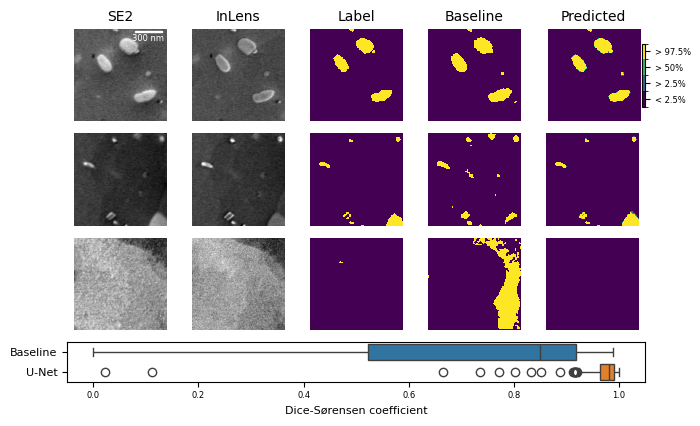

In [23]:
# create figure
n_samples = 3
layout = []
for n in range(n_samples):
    layout.append([f"SE2_{n}", f"InLens_{n}", f"Label_{n}", f"Baseline_{n}", f"Predicted_{n}"])
    layout.append([f"SE2_{n}", f"InLens_{n}", f"Label_{n}", f"Baseline_{n}", f"Predicted_{n}"])

layout.append(["Scores", "Scores", "Scores", "Scores", "Scores"])

fig, ax = plt.subplot_mosaic(layout, figsize=(textwidth, textwidth * 0.61 ))
axs = list(ax.values())

sns.boxplot(data=df, x="score", y="method", hue="method", orient="h", ax=ax["Scores"])
ax["Scores"].set_xlabel("Dice-Sørensen coefficient")
ax["Scores"].set_ylabel("")
# increase ytick font size
ax["Scores"].tick_params(axis='y', labelsize=8)
plot_predictions(model=model, test_data_loader=test_loader, trainer=trainer, n_samples=n_samples, axs=axs[:n_samples * 5], fig=fig)
fig.tight_layout()
fig.savefig(figure_path / "figure_3_model_evaluation.svg", dpi=300, bbox_inches="tight")

## Figure 4: Transfer to unseen image from different experiment

In [24]:
def merge_tiles(tiles: np.ndarray, full_shape: tuple, tile_size: int = 128, stride: int = 128):
    full_image = torch.zeros((1, *full_shape[1:]), dtype=torch.float32).to(tiles.device)
    count_map = torch.zeros_like(full_image, dtype=torch.float32).to(tiles.device)
    C, H, W = full_image.shape
    idx = 0
    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):
            full_image[:, y:y+tile_size, x:x+tile_size] += tiles[idx]
            count_map[:, y:y+tile_size, x:x+tile_size] += 1
            idx += 1
    full_image /= torch.maximum(count_map, torch.tensor(1.).to(tiles.device))
    return full_image[0]

def plot_whole_image_comparison(model: SegmentationModel, trainer: pl.Trainer, image_file: Path, label_file: Path, tile_size: int = 128, stride: int = 128, device="cpu"):
    # load full image
    optimal_T = torch.Tensor([1.87117]).to(device_name)  # determined from the validation set in the notebook Uncertainty_quantification.ipynb

    se2, inlens = read_image_pair(image_file)
    full_image = np.asarray([se2, inlens])
    full_image_tensor = torch.tensor(full_image, dtype=torch.float32)

    # load label
    full_label = imread(label_file)

    # baseline
    baseline_full = classical_segmentation(full_image_tensor)

    # pad image to be divisible by stride
    _, H, W = full_image_tensor.shape
    pad_h = (stride - H % stride) % stride
    pad_w = (stride - W % stride) % stride
    full_image_tensor_padded = torch.nn.functional.pad(full_image_tensor, (0, pad_w, 0, pad_h), mode="reflect")

    # tiling inputs & labels
    tiles = tile_image(full_image_tensor_padded.numpy(), tile_size, stride)

    tiles_tensor = torch.tensor(tiles, dtype=torch.float32)

    # dataset (inputs, labels) -> we can just use inputs twice here, because labels are not used for prediction
    tile_ds = torch.utils.data.TensorDataset(tiles_tensor, tiles_tensor)
    tile_dl = torch.utils.data.DataLoader(tile_ds, batch_size=8, shuffle=False)

    # prediction
    logits = trainer.predict(model, tile_dl)
    logits = torch.cat(logits, dim=0).to(device_name)
    pred_tiles = logits_to_confidence_map(logits, optimal_T, device=device_name)  # (N, 1, t, t)

    # merge predictions back to full image
    _, Hp, Wp = full_image_tensor_padded.shape
    full_pred_mask = merge_tiles(pred_tiles, full_shape=(1, Hp, Wp),
                                 tile_size=tile_size, stride=stride)
    # crop to original size
    full_pred_mask = full_pred_mask[:H, :W]

    # calculate scores
    full_label_tensor = torch.tensor((full_label > 0), dtype=torch.float32).to(device_name).unsqueeze(0).unsqueeze(0)
    baseline_full_tensor = torch.tensor(baseline_full, dtype=torch.float32).to(device_name).unsqueeze(0).unsqueeze(0)
    full_pred_mask_tensor = full_pred_mask.to(device_name).unsqueeze(0).unsqueeze(0)
    baseline_score = 1 - model.dice_loss(baseline_full_tensor, full_label_tensor)
    unet_score = 1 - model.dice_loss(full_pred_mask_tensor > 1, full_label_tensor)
    print(f"Baseline score on full image: {baseline_score.item():.3f}")
    print(f"U-Net score on full image: {unet_score.item():.3f}")

    fig, ax = plt.subplots(1, 4, figsize=(textwidth, 1.31))

    combined_input = np.stack([se2, inlens], axis=0)
    ax[0].imshow(np.max(combined_input, axis=0), cmap="gray")
    ax[0].set_title("Input (SE2+InLens)")
    full_image_scalebar_length = 2000  # nanometers
    full_image_scalebar_length_px = full_image_scalebar_length / pixel_size  # in pixels
    scalebar = AnchoredSizeBar(
        ax[0].transData,
        full_image_scalebar_length_px,
        f"{full_image_scalebar_length // 1000} µm",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 6},
    )
    ax[0].add_artist(scalebar)

    plot_as_confidence_map((full_label > 0) * 3, ax=ax[1], fig=fig, color_bar=False)
    ax[1].set_title("Label")

    plot_as_confidence_map((baseline_full > 0) * 3, ax=ax[2], fig=fig, color_bar=False)
    ax[2].set_title("Baseline")

    plot_as_confidence_map(full_pred_mask.cpu(), ax=ax[3], fig=fig, color_bar=True)
    ax[3].set_title("U-Net Prediction")

    for a in ax:
        a.axis("off")

    plt.tight_layout()
    fig.savefig(figure_path / "figure_4_whole_image_evaluation.svg", dpi=300)
    plt.show()

/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_8043/59486730.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  baseline_full_tensor = torch.tensor(baseline_full, dtype=torch.float32).to(device_name).unsqueeze(0).unsqueeze(0)


Baseline score on full image: 0.907
U-Net score on full image: 0.954


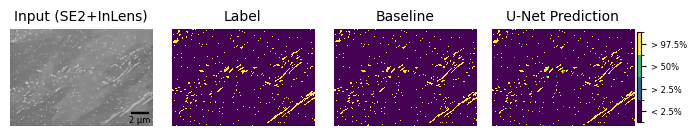

In [25]:
image_file = image_path.parent / "hold-out" / "WD6mm_47.tif"
label_file = image_path.parent / "hold-out" / "WD6mm_47_label.png"
plot_whole_image_comparison(model, trainer, image_file, label_file)